<a href="https://colab.research.google.com/github/dsadasafd/GAN/blob/main/mnist_cgan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('./mount')

Mounted at ./mount


In [3]:
import torch
import torch.nn as nn
import numpy, pandas, random
import matplotlib.pyplot as plt
from torch.utils.data import Dataset


In [4]:
class MnistDataset(Dataset):


  # 超调用继承
  def __init__(self, csv_file):

    self.data_df = pandas.read_csv(csv_file, header=None)
    pass



  def __len__(self):
    return len(self.data_df)



  def __getitem__(self, index):

    # dataset body content
    label = self.data_df.iloc[index, 0]
    label_tensor = torch.zeros((10))
    label_tensor[label] = 1.0

    image_data_tensor = torch.FloatTensor(self.data_df.iloc[index, 1:].values)/255.0

    return label, image_data_tensor, label_tensor



  def plot_image(self, index):

    image_arr = self.data_df.iloc[index, 1:].values.reshape(28,28)
    plt.imshow(image_arr, interpolation='none', cmap='Blues')
    plt.title('label = ' + str(self.data_df.iloc[index, 0]))

    pass


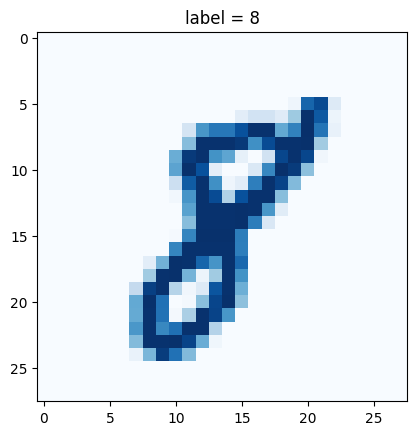

In [6]:
## load data
mnist_dataset = MnistDataset('mount/My Drive/Colab Notebooks/mnist_data/mnist_train.csv')
mnist_dataset.plot_image(17)

In [7]:
# 创建一个判别器

class Discriminator(nn.Module):

  def __init__(self):

    # 初始化继承父类
    super().__init__()

    # 构建网络body
    self.model = nn.Sequential(
        nn.Linear(784+10, 200),
        nn.LeakyReLU(0.02),

        nn.LayerNorm(200),

        nn.Linear(200, 1),
        nn.Sigmoid()
    )

    # 损失函数使用MSELoss
    self.loss_function = nn.BCELoss()

    # 优化器使用
    self.optimiser = torch.optim.Adam(self.parameters(), lr=0.0001)

    # 计数器和loss记录
    self.counter = 0
    self.progress = []

    pass



  def forward(self, image_data_tensor, label_tensor):
    # 拼接标签和像素张量
    inputs = torch.cat((image_data_tensor, label_tensor))
    return self.model(inputs)



  def train(self, inputs, label_tensor, targets_tensor):

    outputs = self.forward(inputs, label_tensor)
    loss = self.loss_function(outputs, targets_tensor)

    # 记录训练过程
    self.counter += 1

    if (self.counter % 10 == 0):
      self.progress.append(loss.item())
      pass

    if (self.counter % 10000 == 0):
      print('counter = ', self.counter)
      pass

    self.optimiser.zero_grad()
    loss.backward()
    self.optimiser.step()

    pass

  def plot_progress(self):

    df = pandas.DataFrame(self.progress, columns=['loss'])
    df.plot(ylim=(0), figsize=(16, 8), alpha=0.1, marker='.', grid=True, yticks=(0.0, 0.25, 0.5, 1.0, 5.0))
    pass


In [8]:
#############
def generate_random(size):

  random_data = torch.rand(size)

  return random_data


###########
def generate_random_seed(size):

  random_data = torch.randn(size)

  return random_data

###########
def generate_random_one_hot(size):

  label_tensor = torch.zeros(size)
  random_idx = random.randint(0, size-1)
  label_tensor[random_idx] = 1.0

  return label_tensor


In [9]:
%%time

D = Discriminator()

# label_tensor 实际就是 target_tensor

for label, image_data_tensor, label_tensor in mnist_dataset:

  # 训练真实数据
  D.train(image_data_tensor, label_tensor, torch.FloatTensor([1.0]))

  # 训练生成数据
  D.train(generate_random(784), generate_random_one_hot(10), torch.FloatTensor([0.0]))

  pass

counter =  10000
counter =  20000
counter =  30000
counter =  40000
counter =  50000
counter =  60000
counter =  70000
counter =  80000
counter =  90000
counter =  100000
counter =  110000
counter =  120000
CPU times: user 4min 22s, sys: 362 ms, total: 4min 22s
Wall time: 4min 41s


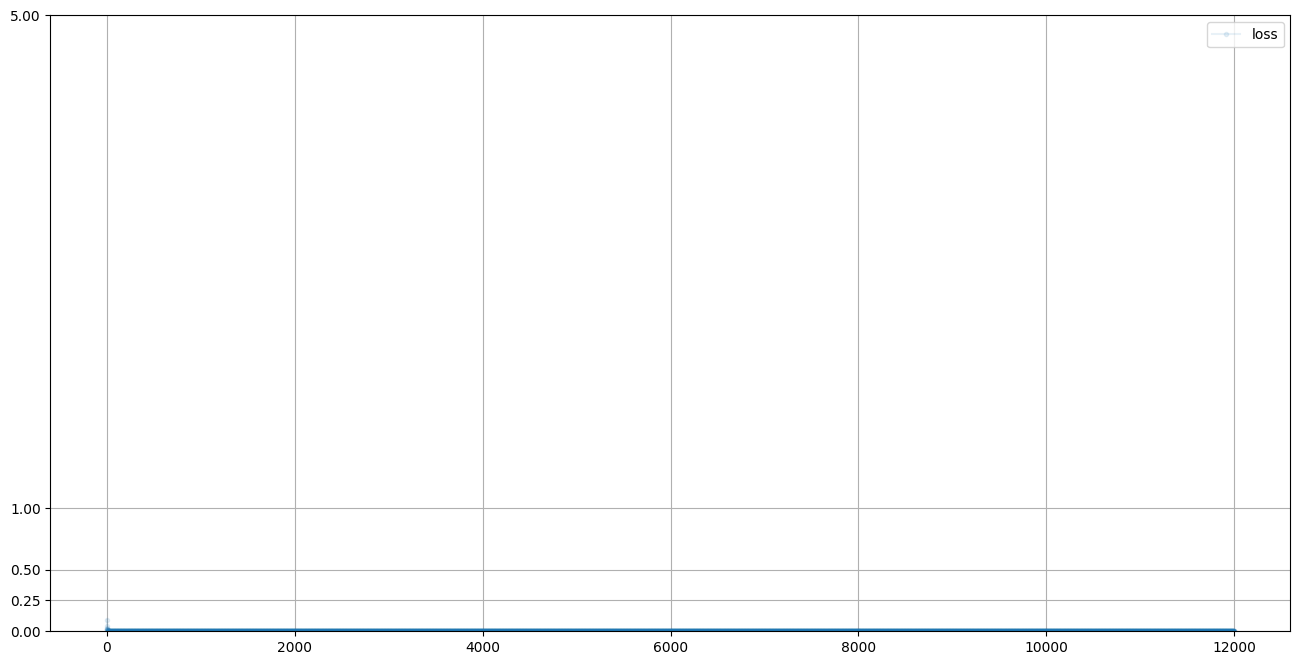

In [10]:
D.plot_progress()

In [11]:
# 测试一下鉴别器
for i in range(4):
  label, image_data_tensor, label_tensor = mnist_dataset[random.randint(0, 60000)]

  print(D.forward(image_data_tensor, label_tensor).item())

for j in range(4):
  print(D.forward(generate_random(784), generate_random_one_hot(10)).item())

1.0
1.0
1.0
1.0
9.463531520925716e-12
9.935304315367155e-12
8.822176496281475e-12
8.949985717821018e-12


In [14]:
# 创建生成器

class Generator(nn.Module):


  def __init__(self):
    super().__init__()
    pass

    self.model = nn.Sequential(
        nn.Linear(100+10,200),
        nn.LeakyReLU(0.02),

        nn.LayerNorm(200),

        nn.Linear(200,784),
        nn.Sigmoid()
    )

    self.optimiser = torch.optim.Adam(self.parameters(), lr=0.0001)

    self.counter = 0
    self.progress = []

    pass



  def forward(self, seed_tensor, label_tensor):

    inputs = torch.cat((seed_tensor, label_tensor))

    return self.model(inputs)



  def train(self, D, inputs, label_tensor, targets):

    # 计算生成器和判别器的输出值
    g_outputs = self.forward(inputs, label_tensor)
    d_outputs = D.forward(g_outputs, label_tensor)

    loss = D.loss_function(d_outputs, targets)

    self.counter += 1
    if (self.counter % 10 == 0):
      self.progress.append(loss.item())
      pass

    # 反向传播梯度优化权重
    self.optimiser.zero_grad()
    loss.backward()
    self.optimiser.step()

    pass


  def plot_progress(self):

    df = pandas.DataFrame(self.progress, columns=['loss'])
    df.plot(ylim=(0), figsize=(16, 8), alpha=0.1, marker='.', grid=True, yticks=(0.0, 0.25, 0.5, 1.0, 5.0))
    pass



  def plot_image(self, label):

    label_tensor = torch.zeros((10))
    label_tensor[label] = 1.0

    # 画出6个不同的子图
    f, axarr = plt.subplots(2,3, figsize=(16,8))
    for i in range(2):
      for j in range(3):
        img = G.forward(generate_random_seed(100), label_tensor)
        axarr[i,j].imshow(img.detach().cpu().numpy().reshape(28,28), interpolation='nearest', cmap='Blues')








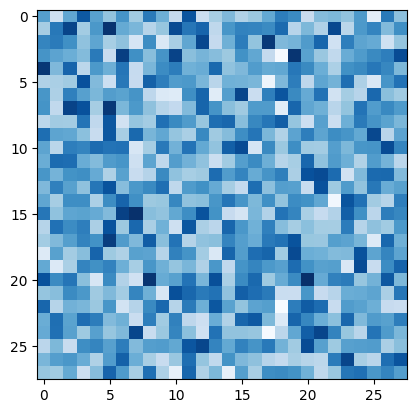

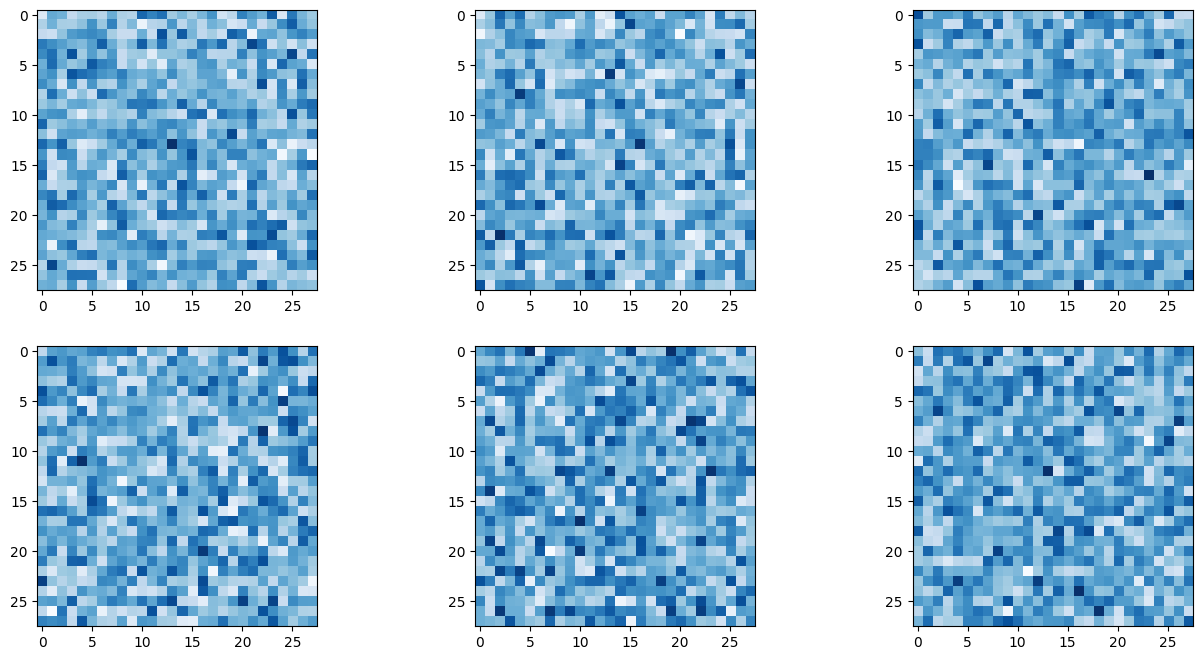

In [16]:
G = Generator()

G_output = G.forward(generate_random_seed(100), generate_random_one_hot(10))

image_data = G_output.detach().cpu().numpy().reshape(28, 28)

plt.imshow(image_data, interpolation='none', cmap='Blues')

G.plot_image(3)


In [25]:
## train the Gan

%%time

D = Discriminator()
G = Generator()
epochs = 12

for epoch in range(epochs):

  print('epoch = ', epoch+1)

  for label, image_data_tensor, label_tensor in mnist_dataset:

    # 真实数据训练
    D.train(image_data_tensor, label_tensor, torch.FloatTensor([1.0]))

    # 生成器数据的训练()
    random_label_tensor = generate_random_one_hot((10))
    D.train(G.forward(generate_random_seed(100), random_label_tensor).detach(), random_label_tensor, torch.FloatTensor([0.0]))

    # 训练生成器
    random_label_tensor = generate_random_one_hot(10)
    G.train(D, generate_random_seed(100), random_label_tensor, torch.FloatTensor([1.0]))

    pass


epoch =  1
counter =  10000
counter =  20000
counter =  30000
counter =  40000
counter =  50000
counter =  60000
counter =  70000
counter =  80000
counter =  90000
counter =  100000
counter =  110000
counter =  120000
epoch =  2
counter =  130000
counter =  140000
counter =  150000
counter =  160000
counter =  170000
counter =  180000
counter =  190000
counter =  200000
counter =  210000
counter =  220000
counter =  230000
counter =  240000
epoch =  3
counter =  250000
counter =  260000
counter =  270000
counter =  280000
counter =  290000
counter =  300000
counter =  310000
counter =  320000
counter =  330000
counter =  340000
counter =  350000
counter =  360000
epoch =  4
counter =  370000
counter =  380000
counter =  390000
counter =  400000
counter =  410000
counter =  420000
counter =  430000
counter =  440000
counter =  450000
counter =  460000
counter =  470000
counter =  480000
epoch =  5
counter =  490000
counter =  500000
counter =  510000
counter =  520000
counter =  530000


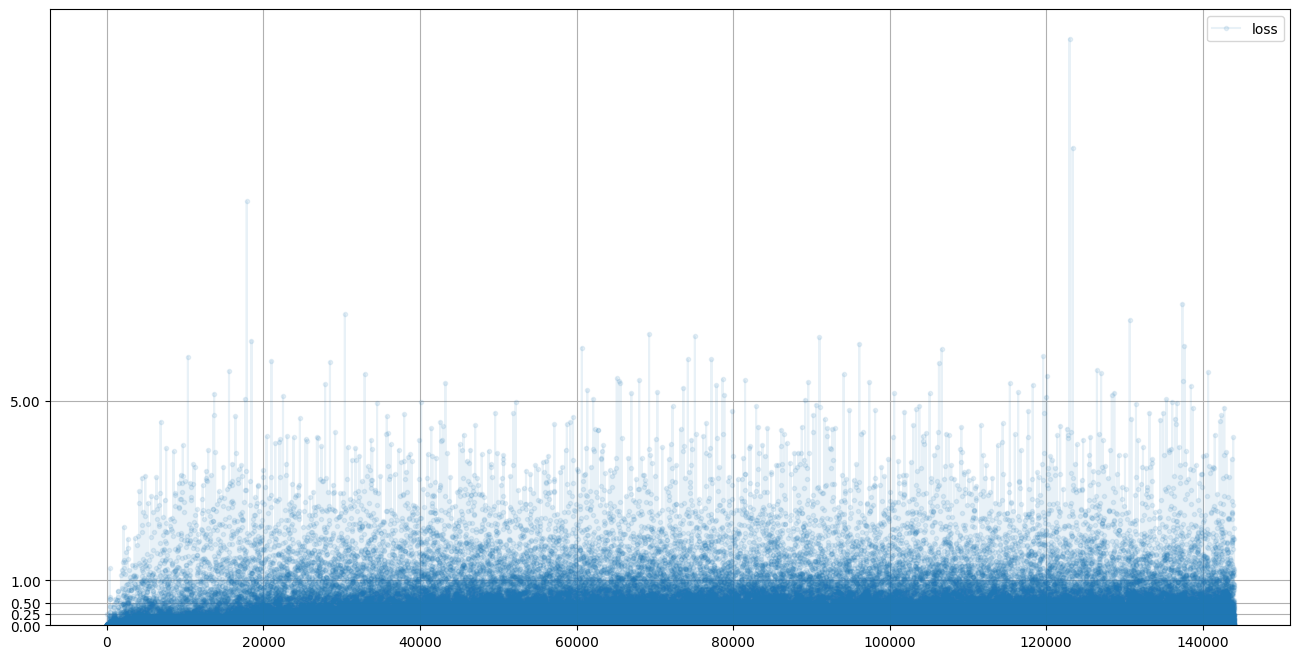

In [26]:
D.plot_progress()

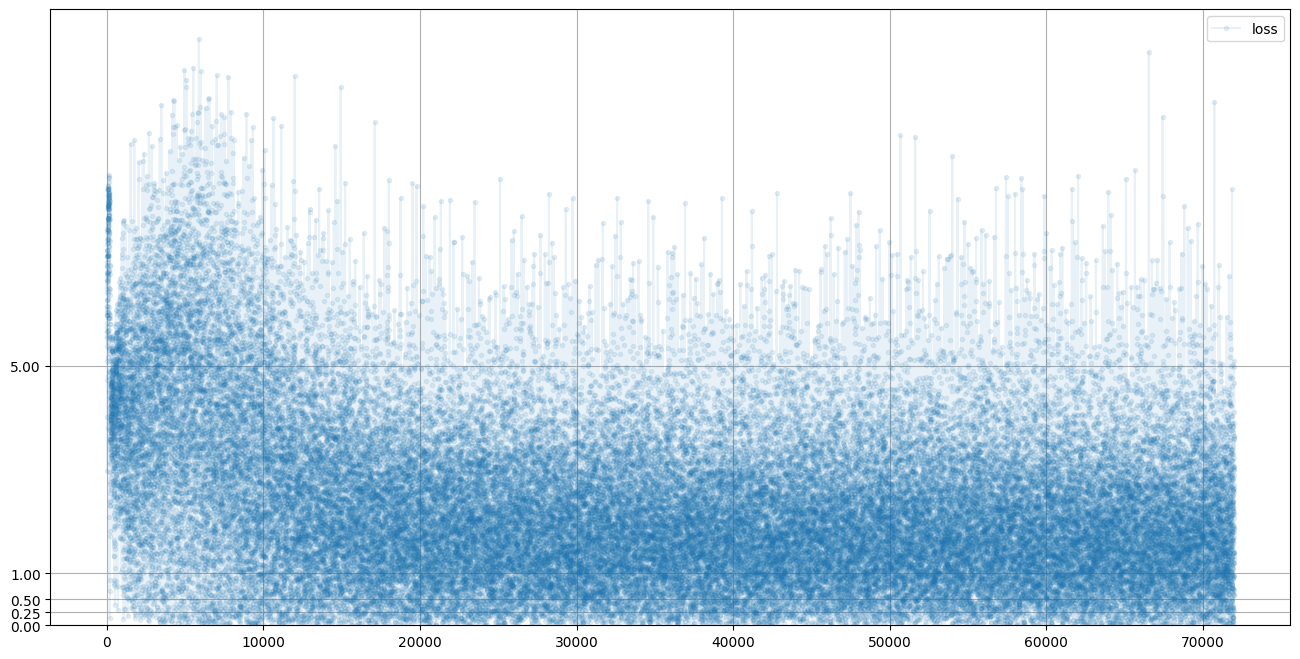

In [27]:
#G.progress
G.plot_progress()

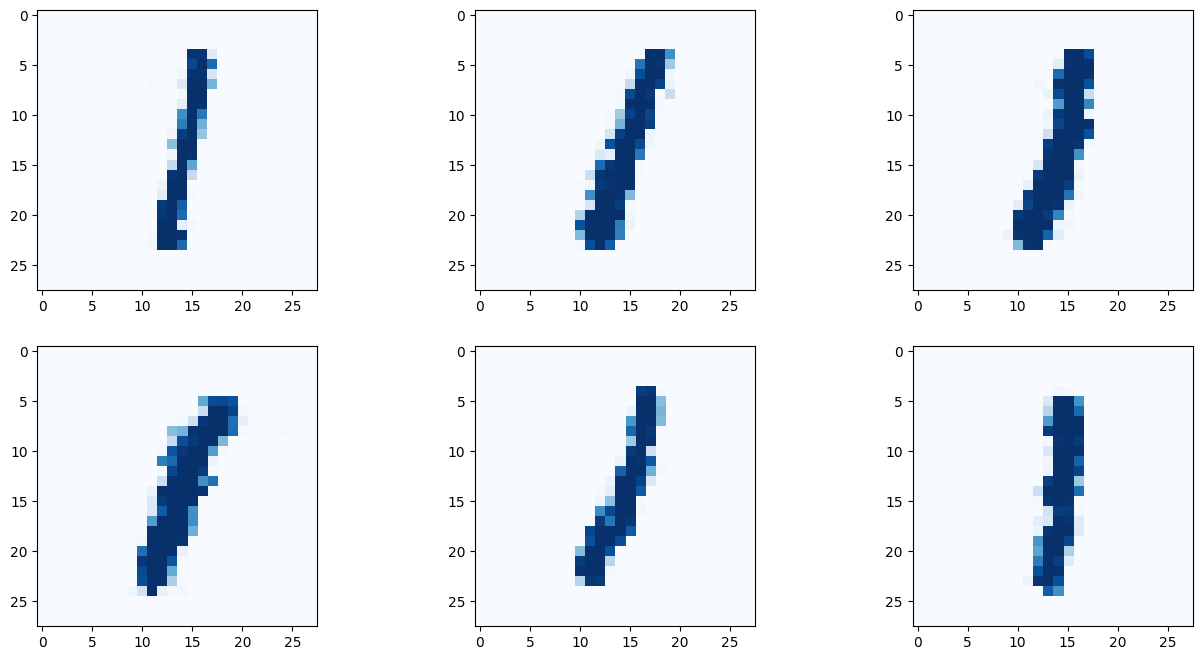

In [28]:
G.plot_image(1)

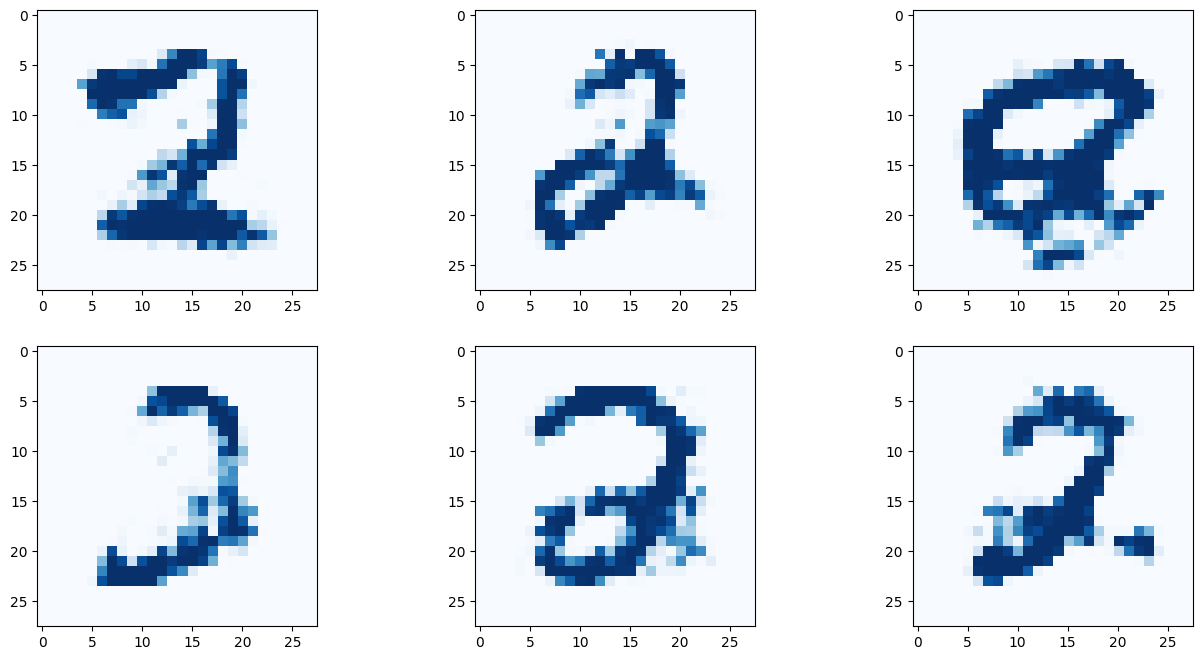

In [29]:
G.plot_image(2)

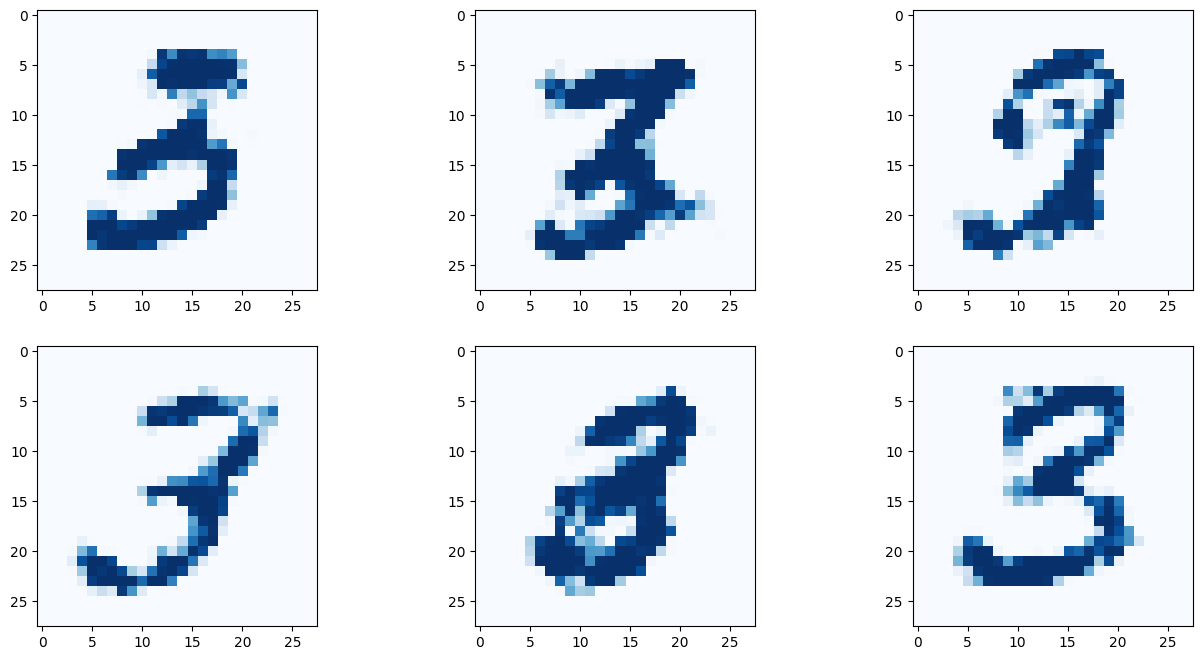

In [30]:
G.plot_image(3)

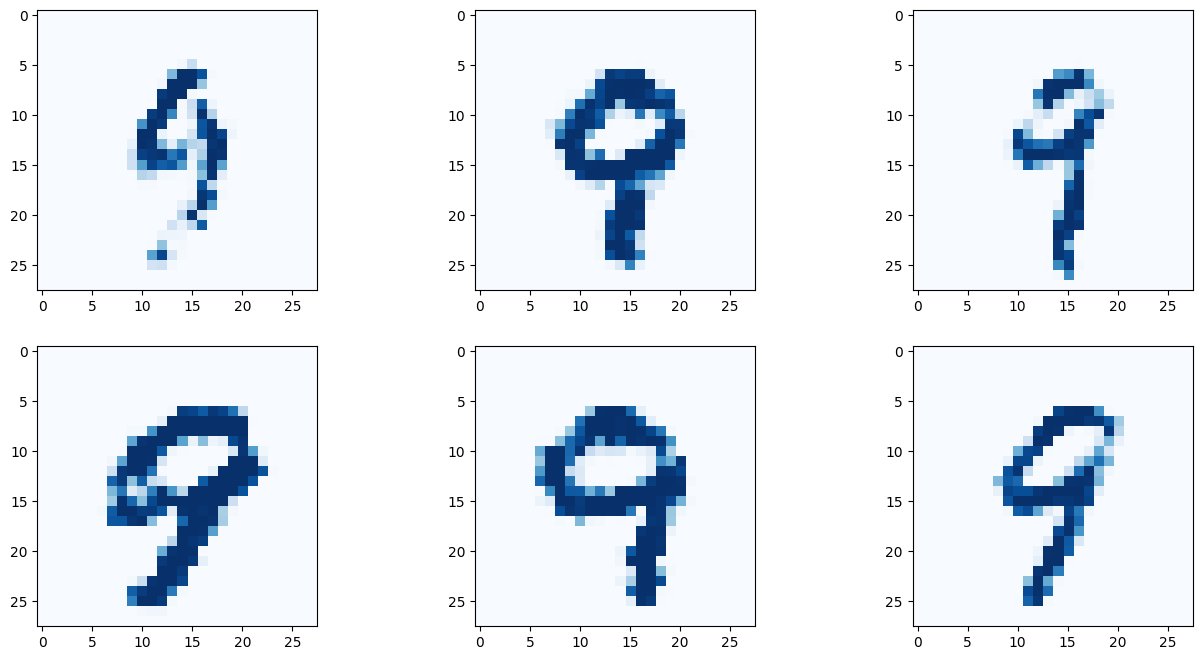

In [31]:
G.plot_image(9)